In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.layers import Activation, Dense, Dropout, LSTM
from keras.models import Sequential
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler

In [2]:
# Load data into a DataFrame
df = pd.read_csv("./Resources/working_dataset.csv").set_index("time")
df.index = pd.to_datetime(df.index)
df.head()

,Symbol,PriceUSD,Percent of Change
time,,,
2010-07-18,btc,0.085840,0
2010-07-19,btc,0.080800,0
2010-07-20,btc,0.074736,0
2010-07-21,btc,0.079193,0
2010-07-22,btc,0.058470,0


In [3]:
# Filter the dataset for only Ethereum data, with symbol "Eth"
ethereum = df.loc[df["Symbol"] == "eth"]
ethereum.head()

,Symbol,PriceUSD,Percent of Change
time,,,
2015-08-08,eth,1.19999,0
2015-08-09,eth,1.19999,0
2015-08-10,eth,1.19999,0
2015-08-11,eth,0.99000,0
2015-08-12,eth,1.28800,0


In [4]:
# Check how many data points we are working with
ethereum.count()

Symbol               2763
PriceUSD             2763
Percent of Change    2763
dtype: int64

In [5]:
# Drop unnecessary columns, focusing on the main feature which is Price [USD]
ethereum_df = ethereum.drop(["Symbol", "Percent of Change"], axis=1)
ethereum_df

,PriceUSD
time,
2015-08-08,1.199990
2015-08-09,1.199990
2015-08-10,1.199990
2015-08-11,0.990000
2015-08-12,1.288000
...,...
2023-02-25,1593.903917
2023-02-26,1640.578514
2023-02-27,1633.629326


In [6]:
# Function to prepare data for training and testing
def prepare_data(data, sequence_length):
    # Normalize data using MinMaxScaler
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(data)

    # Split data into training and testing sets
    training_data = scaled_data[:int(0.8*len(data)), :]
    testing_data = scaled_data[int(0.8*len(data)):, :]

    # Create sequences of data
    X_train, y_train = create_sequences(training_data, sequence_length)
    X_test, y_test = create_sequences(testing_data, sequence_length)
    # Return data and scaler object
    return X_train, y_train, X_test, y_test, scaler


In [7]:
# Function to create sliding window of sequences that will be used when splitting into training and testing sets
def create_sequences(data, sequence_length):
    X = []
    y = []
    # Loop through data with sequence_length steps at a time
    for i in range(len(data)-sequence_length-1):
        # Append a sequence of length sequence_length to X
        X.append(data[i:(i+sequence_length), :])
        # Append the next value in the sequence to y
        y.append(data[i+sequence_length, 0])
    # Convert X and y to numpy arrays
    X = np.array(X)
    y = np.array(y)
    return X, y

In [8]:
# Function that builds our LSTM model, with the requirement of the input shape to be three dimensional.
def build_model(input_shape):
    model = Sequential()
    model.add(LSTM(50, return_sequences=True, input_shape=input_shape))
    model.add(LSTM(50, return_sequences=True))
    model.add(LSTM(50))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

In [9]:
# Prepare data
sequence_length = 30
X_train, y_train, X_test, y_test, scaler = prepare_data(ethereum_df.values, sequence_length)

In [10]:
# Confirm if the input training set is three dimensional
print(f' X (Training) Shape: {X_train.shape}')

 X (Training) Shape: (2179, 30, 1)


In [11]:
# Build model
input_shape = (X_train.shape[1], X_train.shape[2])
model = build_model(input_shape)

In [12]:
# Train/Fit LSTM model to training data
history = model.fit(X_train, y_train, epochs=50, batch_size=64, validation_data=(X_test, y_test), verbose=1)

Epoch 1/50
35/35 [==============================] - 53s 559ms/step - loss: 0.0051 - val_loss: 0.0055
Epoch 2/50
35/35 [==============================] - 11s 318ms/step - loss: 0.0011 - val_loss: 0.0048
Epoch 3/50
35/35 [==============================] - 11s 322ms/step - loss: 8.4052e-04 - val_loss: 0.0107
Epoch 4/50
35/35 [==============================] - 11s 309ms/step - loss: 8.1340e-04 - val_loss: 0.0035
Epoch 5/50
35/35 [==============================] - 11s 321ms/step - loss: 6.3135e-04 - val_loss: 0.0091
Epoch 6/50
35/35 [==============================] - 12s 333ms/step - loss: 6.3274e-04 - val_loss: 0.0031
Epoch 7/50
35/35 [==============================] - 11s 326ms/step - loss: 6.2651e-04 - val_loss: 0.0053
Epoch 8/50
35/35 [==============================] - 12s 333ms/step - loss: 4.7665e-04 - val_loss: 0.0033
Epoch 9/50
35/35 [==============================] - 12s 342ms/step - loss: 3.8178e-04 - val_loss: 0.0029
Epoch 10/50
35/35 [==============================] - 11s 316ms/

17/17 [==============================] - 18s 112ms/step


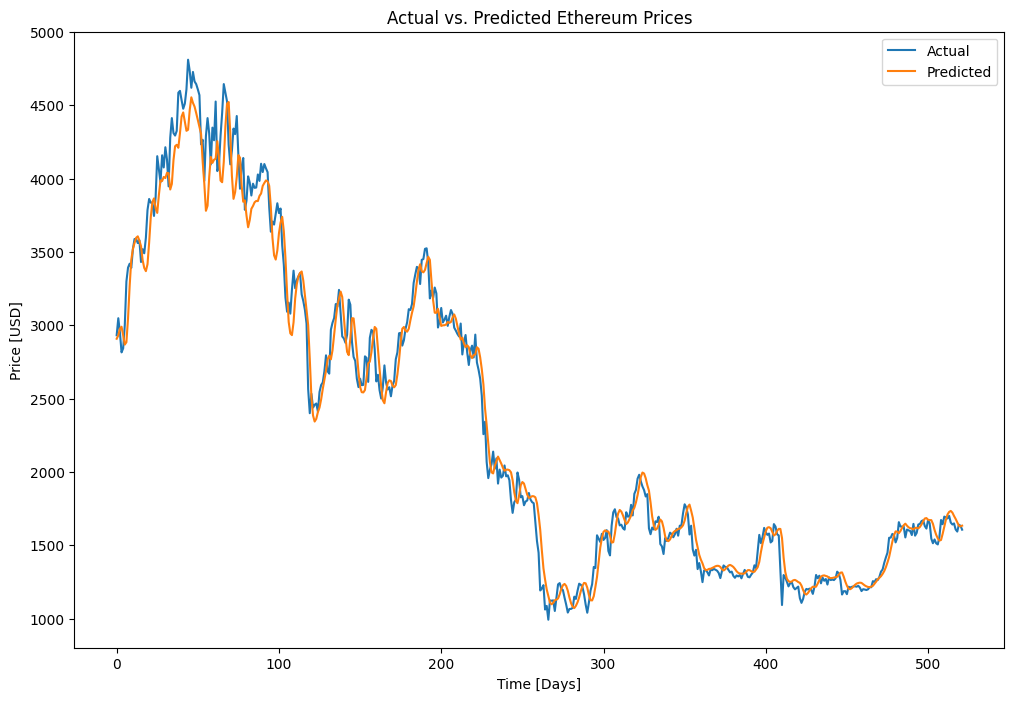

In [13]:
# Make predictions on testing data
predictions = model.predict(X_test)

# Denormalize predictions and actual values
y_pred_inv = scaler.inverse_transform(predictions)
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))

# Plot actual vs predicted prices
plt.figure(figsize=(12, 8))
plt.plot(y_test_inv, label='Actual')
plt.plot(y_pred_inv, label='Predicted')
plt.xlabel('Time [Days]')
plt.ylabel('Price [USD]')
plt.title('Actual vs. Predicted Ethereum Prices')
plt.legend()
plt.show()


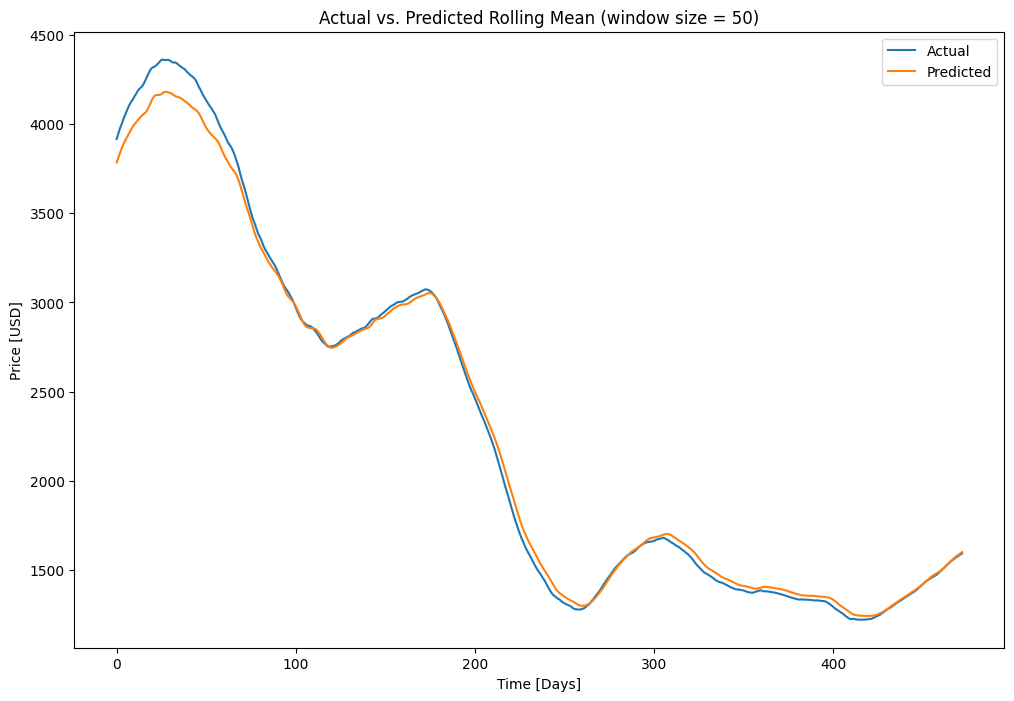

In [14]:
# Plot actual vs predicted prices with a rolling window
window_size = 50
rolling_y_test = pd.Series(y_test_inv.reshape(-1)).rolling(window_size).mean()[window_size-1:].values
rolling_y_pred = pd.Series(y_pred_inv.reshape(-1)).rolling(window_size).mean()[window_size-1:].values

plt.figure(figsize=(12, 8))
plt.plot(rolling_y_test, label='Actual')
plt.plot(rolling_y_pred, label='Predicted')
plt.title('Actual vs. Predicted Rolling Mean (window size = {})'.format(window_size))
plt.xlabel('Time [Days]')
plt.ylabel('Price [USD]')
plt.legend()
plt.show()


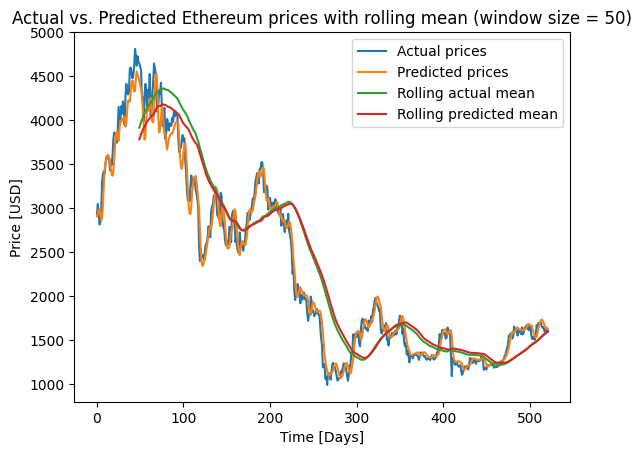

In [15]:
# Assume `y_test` is the actual Ethereum prices and `predictions` is the predicted prices
# Convert them into pandas DataFrame for easier manipulation
y_test_df = pd.DataFrame(y_test_inv, columns=['actual'])
predictions_df = pd.DataFrame(y_pred_inv, columns=['predicted'])

# Concatenate the two DataFrames into one
results_df = pd.concat([y_test_df, predictions_df], axis=1)

# Set the window size for the rolling window
window_size = 50

# Calculate the rolling mean for both the actual and predicted prices
results_df['actual_mean'] = results_df['actual'].rolling(window_size).mean()
results_df['predicted_mean'] = results_df['predicted'].rolling(window_size).mean()

# Plot the actual and predicted prices with the rolling mean
plt.plot(results_df['actual'], label='Actual prices')
plt.plot(results_df['predicted'], label='Predicted prices')
plt.plot(results_df['actual_mean'], label='Rolling actual mean')
plt.plot(results_df['predicted_mean'], label='Rolling predicted mean')
plt.legend()
plt.title('Actual vs. Predicted Ethereum prices with rolling mean (window size = {})'.format(window_size))
plt.xlabel('Time [Days]')
plt.ylabel('Price [USD]')
plt.show()


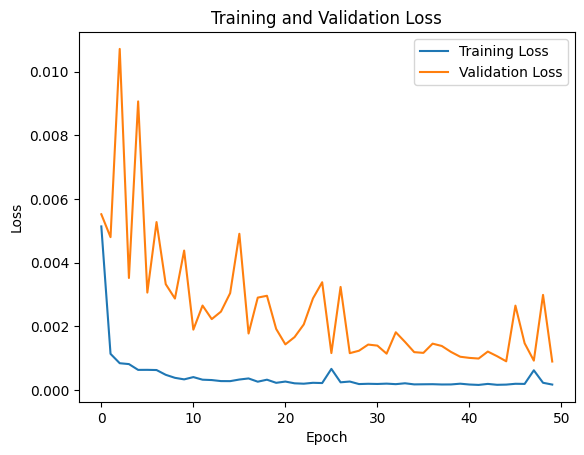

In [16]:
# Plot the training and validation loss over time/epochs
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot a line chart of the training and validation MSE loss over the training epochs.

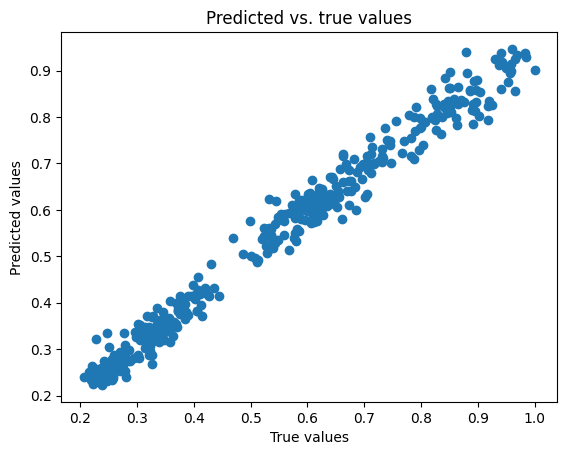

In [17]:
# Plot of the predicted values against the true values, which can help you visualize how well the model is able to predict the crypto prices.
plt.scatter(y_test, predictions)
plt.title('Predicted vs. true values')
plt.xlabel('True values')
plt.ylabel('Predicted values')
plt.show()

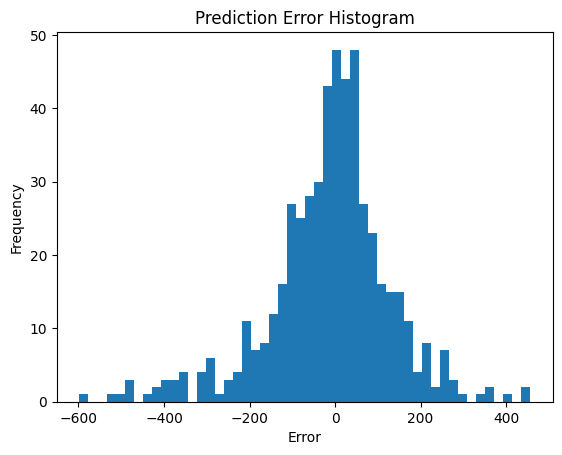

In [18]:
# Calculate prediction errors
errors = y_pred_inv - y_test_inv

# Plot histogram of errors
plt.hist(errors, bins=50)
plt.title('Prediction Error Histogram')
plt.xlabel('Error')
plt.ylabel('Frequency')
plt.show()

In [19]:
# Calculate MSE and RMSE
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Compute mean absolute error
mae = mean_absolute_error(y_test, predictions)

# Compute coefficient of determination
r2 = r2_score(y_test, predictions)

# Compute mean squared error using evaluate method
mse_keras = model.evaluate(X_test, y_test)

# Calculate RMSE from MSE
rmse_keras = np.sqrt(mse_keras)

print('MSE (Keras):', mse_keras)
print('RMSE (Keras):', rmse_keras)
print('MAE:', mae)
print('R²:', r2)

17/17 [==============================] - 2s 92ms/step - loss: 8.9397e-04
MSE (Keras): 0.0008939711260609329
RMSE (Keras): 0.02989934992706251
MAE: 0.021308792015352036
R²: 0.9820742438468109


In [21]:
# Save previous predictions
previous_predictions_df = predictions_df.copy()

# Get last n rows of ethereum_df and set index of previous_predictions_df to match
n = len(previous_predictions_df)
previous_predictions_df.index = ethereum_df.iloc[-n:].index

In [22]:
# Use the model to predict future prices
# First, get the last sequence of data from the training set
last_sequence = X_train[-1,:,:]
# Generate the future date range
future_dates = pd.date_range(start=ethereum_df.index[-1], periods=60, freq='D')
# Create an empty array to hold the predicted prices
predicted_prices = np.zeros((60, 1))
# Iterate over the future date range
for i, date in enumerate(future_dates):
    # Predict the price for the next day using the last sequence of data
    predicted_price = model.predict(last_sequence.reshape(1, last_sequence.shape[0], last_sequence.shape[1]))
    # Add the predicted price to the array
    predicted_prices[i, 0] = predicted_price
    # Update the last sequence of data with the predicted price
    last_sequence = np.vstack((last_sequence[1:], predicted_price))

# Invert the scaling of the predicted prices
predicted_prices_inv = scaler.inverse_transform(predicted_prices)

# Create a dataframe with the predicted prices and the corresponding dates
predictions_df2 = pd.DataFrame(predicted_prices_inv, index=future_dates, columns=['predicted'])

1/1 [==============================] - 0s 135ms/step


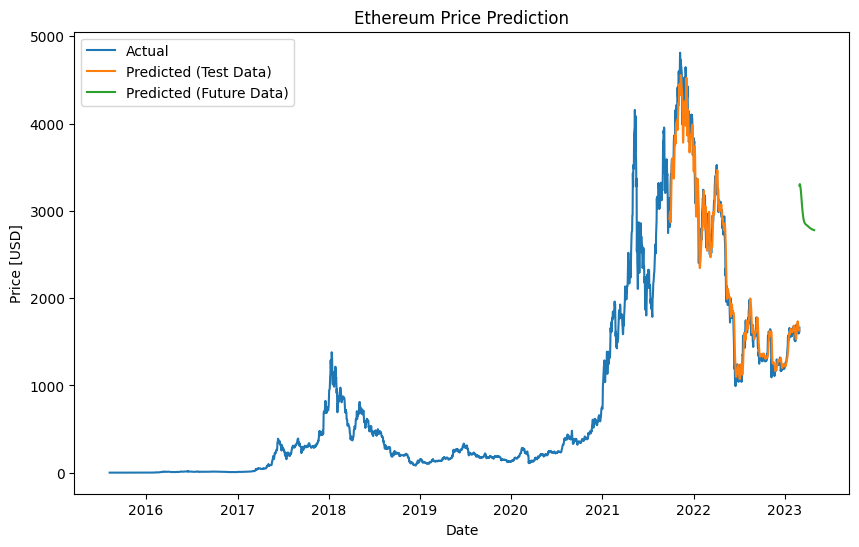

In [23]:
# Plot actual vs predicted values
plt.figure(figsize=(10, 6))
plt.plot(ethereum_df.index, ethereum_df.values, label='Actual')
plt.plot(previous_predictions_df.index, previous_predictions_df['predicted'], label='Predicted (Test Data)')
plt.plot(predictions_df2.index, predictions_df2['predicted'], label='Predicted (Future Data)')
plt.legend()
plt.title('Ethereum Price Prediction')
plt.xlabel('Date')
plt.ylabel('Price [USD]')
plt.show()

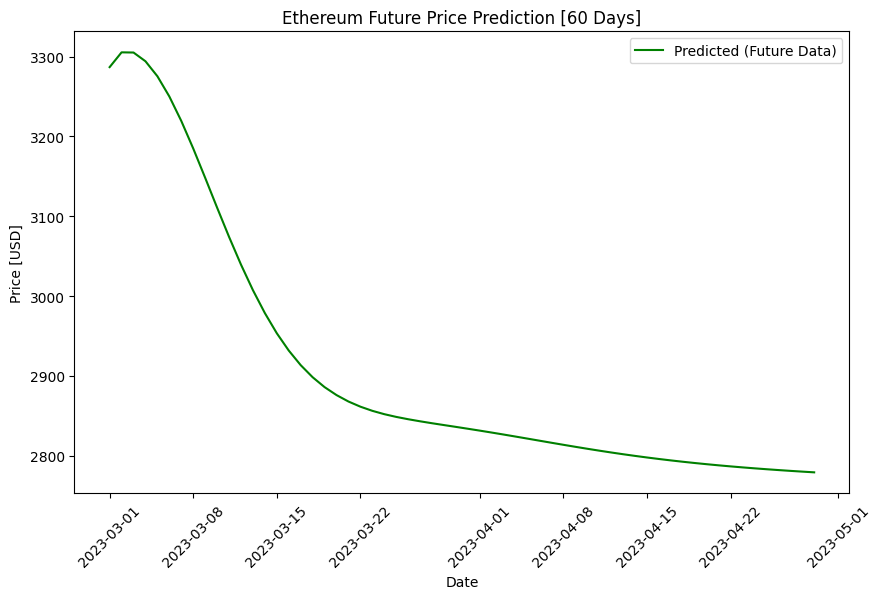

In [24]:
# Plot actual vs predicted values
plt.figure(figsize=(10, 6))
plt.plot(predictions_df2.index, predictions_df2['predicted'], color="green", label='Predicted (Future Data)')
plt.legend()
plt.title('Ethereum Future Price Prediction [60 Days]')
plt.xlabel('Date')
plt.ylabel('Price [USD]')
plt.xticks(rotation=45)
plt.show()

In [25]:
previous_predictions_df

,predicted
time,
2021-09-26,2908.501465
2021-09-27,2931.154297
2021-09-28,2977.538330
2021-09-29,2990.603516
2021-09-30,2931.974609
...,...
2023-02-25,1680.197021
2023-02-26,1656.973877
2023-02-27,1634.150635


In [26]:
predictions_df2

,predicted
2023-03-01,3286.696516
2023-03-02,3305.210602
2023-03-03,3304.977481
2023-03-04,3294.052315
2023-03-05,3275.281881
2023-03-06,3249.949351
2023-03-07,3219.318112
2023-03-08,3184.844526
2023-03-09,3148.144387
2023-03-10,3110.769257
